In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
os.listdir('../input')

# Any results you write to the current directory are saved as output.

['efficientnet-keras-source-code',
 'ttagit',
 'severstal-predict-missing-masks',
 'fromtta',
 'severstal-steel-defect-detection']

# base on Severstal: Simple 2-step pipeline 
https://www.kaggle.com/xhlulu/severstal-simple-2-step-pipeline

In [2]:
!pip install ../input/efficientnet-keras-source-code/repository/qubvel-efficientnet-c993591

Processing /kaggle/input/efficientnet-keras-source-code/repository/qubvel-efficientnet-c993591
  Created wheel for efficientnet: filename=efficientnet-0.0.4-cp36-none-any.whl size=17599 sha256=fc09ccc1a74b1ef44aa6c1b76af29b2d41f5f15fbd5fa56d55f660e46d32a0d1
  Stored in directory: /tmp/.cache/pip/wheels/71/5b/7b/ad46760ebf29c8a85233044e3caba4cf19d7e12f1ab41a3862
Successfully built efficientnet


In [3]:
import sys
sys.path.append("../input/ttagit/tta_wrapper-master/tta_wrapper-master/")

In [4]:
import os
import json
import gc

import cv2
import keras
from keras import backend as K
from keras import layers
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.optimizers import Adam
from keras.callbacks import Callback, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split

Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

In [5]:
train_df = pd.read_csv('../input/severstal-steel-defect-detection/train.csv')
train_df['ImageId'] = train_df['ImageId_ClassId'].apply(lambda x: x.split('_')[0])
train_df['ClassId'] = train_df['ImageId_ClassId'].apply(lambda x: x.split('_')[1])
train_df['hasMask'] = ~ train_df['EncodedPixels'].isna()

print(train_df.shape)
train_df.head()

(50272, 5)


,ImageId_ClassId,EncodedPixels,ImageId,ClassId,hasMask
0,0002cc93b.jpg_1,29102 12 29346 24 29602 24 29858 24 30114 24 3...,0002cc93b.jpg,1,True
1,0002cc93b.jpg_2,NaN,0002cc93b.jpg,2,False
2,0002cc93b.jpg_3,NaN,0002cc93b.jpg,3,False
3,0002cc93b.jpg_4,NaN,0002cc93b.jpg,4,False
4,00031f466.jpg_1,NaN,00031f466.jpg,1,False


In [6]:
mask_count_df = train_df.groupby('ImageId').agg(np.sum).reset_index()
mask_count_df.sort_values('hasMask', ascending=False, inplace=True)
print(mask_count_df.shape)
mask_count_df.head()

(12568, 2)


,ImageId,hasMask
10803,db4867ee8.jpg,3.0
11776,ef24da2ba.jpg,3.0
6284,7f30b9c64.jpg,2.0
9421,bf0c81db6.jpg,2.0
9615,c314f43f3.jpg,2.0


In [7]:
sub_df = pd.read_csv('../input/severstal-steel-defect-detection/sample_submission.csv')
sub_df['ImageId'] = sub_df['ImageId_ClassId'].apply(lambda x: x.split('_')[0])
test_imgs = pd.DataFrame(sub_df['ImageId'].unique(), columns=['ImageId'])
test_imgs.head()

,ImageId
0,004f40c73.jpg
1,006f39c41.jpg
2,00b7fb703.jpg
3,00bbcd9af.jpg
4,0108ce457.jpg


In [8]:
non_missing_train_idx = mask_count_df[mask_count_df['hasMask'] > 0]
non_missing_train_idx.head()

,ImageId,hasMask
10803,db4867ee8.jpg,3.0
11776,ef24da2ba.jpg,3.0
6284,7f30b9c64.jpg,2.0
9421,bf0c81db6.jpg,2.0
9615,c314f43f3.jpg,2.0


In [9]:
def load_img(code, base, resize=True):
    path = f'{base}/{code}'
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if resize:
        img = cv2.resize(img, (224, 224))
    
    return img

def validate_path(path):
    if not os.path.exists(path):
        os.makedirs(path)

In [10]:
test_path = '../tmp/test'
validate_path(test_path)

for code in tqdm(test_imgs['ImageId'].values):
    img = load_img(code, base='../input/severstal-steel-defect-detection/test_images')
    path = code.replace('.jpg', '')
    cv2.imwrite(f'{test_path}/{path}.png', img)

test_imgs['ImageId'] = test_imgs['ImageId'].apply(lambda x: x.replace('.jpg', '.png'))
sub_df['ImageId'] = sub_df['ImageId'].apply(lambda x: x.replace('.jpg', '.png'))

100%|██████████| 1801/1801 [00:19<00:00, 94.30it/s]


In [11]:
BATCH_SIZE = 64
def create_test_gen():
    return ImageDataGenerator(rescale=1/255.).flow_from_dataframe(
        test_imgs,
        directory='../tmp/test',
        x_col='ImageId',
        class_mode=None,
        target_size=(256, 256),
        batch_size=BATCH_SIZE,
        shuffle=False
    )

test_gen = create_test_gen()

Found 1801 validated image filenames.


In [12]:
!ls ../input/

efficientnet-keras-source-code	severstal-predict-missing-masks   ttagit
fromtta				severstal-steel-defect-detection


In [13]:
remove_model = load_model('../input/severstal-predict-missing-masks/model.h5')
remove_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 8, 8, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 1024)              4096      
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
__________

In [14]:
test_missing_pred = remove_model.predict_generator(
    test_gen,
    steps=len(test_gen),
    verbose=1
)

test_imgs['missingCount'] = test_missing_pred.argmax(axis=1) + 1
test_imgs.head()

29/29 [==============================] - 12s 427ms/step


,ImageId,missingCount
0,004f40c73.png,1
1,006f39c41.png,1
2,00b7fb703.png,1
3,00bbcd9af.png,1
4,0108ce457.png,1


In [15]:
test_missing_pred.shape

(1801, 1)

In [16]:
test_imgs['missingCount'].value_counts()

1    1801
Name: missingCount, dtype: int64

In [17]:
filtered_test_imgs = test_imgs[test_imgs['missingCount'] < 4]
print(filtered_test_imgs.shape)
filtered_test_imgs.head()

(1801, 2)


,ImageId,missingCount
0,004f40c73.png,1
1,006f39c41.png,1
2,00b7fb703.png,1
3,00bbcd9af.png,1
4,0108ce457.png,1


In [18]:
filtered_mask = sub_df['ImageId'].isin(filtered_test_imgs["ImageId"].values)
filtered_sub_df = sub_df[filtered_mask].copy()
null_sub_df = sub_df[~filtered_mask].copy()
null_sub_df['EncodedPixels'] = null_sub_df['EncodedPixels'].apply(
    lambda x: ' ')

filtered_sub_df['ImageId'] = filtered_sub_df['ImageId'].apply(
    lambda x: x.replace('.png', '.jpg'))

filtered_test_imgs['ImageId'] = filtered_test_imgs['ImageId'].apply(
    lambda x: x.replace('.png', '.jpg'))

filtered_sub_df.reset_index(drop=True, inplace=True)
filtered_test_imgs.reset_index(drop=True, inplace=True)

print(filtered_sub_df.shape)
print(null_sub_df.shape)

filtered_sub_df.head()

(7204, 3)
(0, 3)


,ImageId_ClassId,EncodedPixels,ImageId
0,004f40c73.jpg_1,1 1,004f40c73.jpg
1,004f40c73.jpg_2,1 1,004f40c73.jpg
2,004f40c73.jpg_3,1 1,004f40c73.jpg
3,004f40c73.jpg_4,1 1,004f40c73.jpg
4,006f39c41.jpg_1,1 1,006f39c41.jpg


In [19]:
def mask2rle(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle2mask(rle, input_shape):
    width, height = input_shape[:2]
    
    mask= np.zeros( width*height ).astype(np.uint8)
    
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1
        current_position += lengths[index]
        
    return mask.reshape(height, width).T

def build_masks(rles, input_shape):
    depth = len(rles)
    masks = np.zeros((*input_shape, depth))
    
    for i, rle in enumerate(rles):
        if type(rle) is str:
            masks[:, :, i] = rle2mask(rle, input_shape)
    
    return masks

def build_rles(masks):
    width, height, depth = masks.shape
    
    rles = [mask2rle(masks[:, :, i])
            for i in range(depth)]
    
    return rles

In [20]:
from skimage.color import gray2rgb
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, df, target_df=None, mode='fit',
                 base_path='../input/severstal-steel-defect-detection/train_images',
                 batch_size=32, dim=(256, 1600), n_channels=3,
                 n_classes=4, random_state=2019, shuffle=True,aug=False):
        self.dim = dim
        self.batch_size = batch_size
        self.df = df
        self.mode = mode
        self.base_path = base_path
        self.target_df = target_df
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.random_state = random_state
        self.seq = aug
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_batch = [self.list_IDs[k] for k in indexes]
                
        X = self.__generate_X(list_IDs_batch)
        if self.mode == 'fit':
            y = self.__generate_y(list_IDs_batch)
            return X, y.astype(int)
        
        elif self.mode == 'predict':
            return X

        else:
            raise AttributeError('The mode parameter should be set to "fit" or "predict".')
        
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.seed(self.random_state)
            np.random.shuffle(self.indexes)
    
    def __generate_X(self, list_IDs_batch):
        'Generates data containing batch_size samples'
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        
        # Generate data
        for i, ID in enumerate(list_IDs_batch):
            im_name = self.df['ImageId'].iloc[ID]
            img_path = f"{self.base_path}/{im_name}"
            img = self.__load_grayscale(img_path)
            
            # Store samples
            X[i,] = gray2rgb(img[:,:,0])

        return X
    
    def __generate_y(self, list_IDs_batch):
        y = np.empty((self.batch_size, *self.dim, self.n_classes), dtype=int)
        
        for i, ID in enumerate(list_IDs_batch):
            im_name = self.df['ImageId'].iloc[ID]
            image_df = self.target_df[self.target_df['ImageId'] == im_name]
            
            rles = image_df['EncodedPixels'].values
            masks = build_masks(rles, input_shape=self.dim)
            
            y[i, ] = masks
        return y
    
    def __load_grayscale(self, img_path):
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = img.astype(np.float32) / 255.
        img = np.expand_dims(img, axis=-1)

        return img
    
    def __load_rgb(self, img_path):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype(np.float32) / 255.

        return img

In [21]:
BATCH_SIZE = 8
import imgaug as ia
import imgaug.augmenters as iaa
seq = iaa.Sequential([
    iaa.Sharpen((0.0, 1.0)),       # sharpen the image
    iaa.Fliplr(),
    iaa.Flipud(),
    iaa.ElasticTransformation(alpha=50, sigma=5)  # apply water effect (affects segmaps)
], random_order=True)
train_idx, val_idx = train_test_split(
    non_missing_train_idx.index,  # NOTICE DIFFERENCE
    random_state=2019, 
    test_size=0.15
)

train_generator = DataGenerator(
    train_idx, 
    df=mask_count_df,
    target_df=train_df,
    batch_size=BATCH_SIZE, 
    n_classes=4,
    aug = seq
)

val_generator = DataGenerator(
    val_idx, 
    df=mask_count_df,
    target_df=train_df,
    batch_size=BATCH_SIZE, 
    n_classes=4,
    aug = seq
)

In [22]:
x,y = next(iter(val_generator))
x.shape,y.shape

((8, 256, 1600, 3), (8, 256, 1600, 4))

In [23]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [24]:
from keras.losses import binary_crossentropy

from keras.preprocessing.image import load_img
from keras import Model
from keras.callbacks import  ModelCheckpoint
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout,BatchNormalization
from keras.layers import Conv2D, Concatenate, MaxPooling2D
from keras.layers import UpSampling2D, Dropout, BatchNormalization
from tqdm import tqdm_notebook
from keras import initializers
from keras import regularizers
from keras import constraints
from keras.utils import conv_utils
from keras.utils.data_utils import get_file
from keras.engine.topology import get_source_inputs
from keras.engine import InputSpec
from keras import backend as K
from keras.layers import LeakyReLU
from keras.layers import ZeroPadding2D
from keras.losses import binary_crossentropy
import keras.callbacks as callbacks
from keras.callbacks import Callback
from keras.applications.xception import Xception
from keras.layers import multiply


from keras import optimizers
from keras.legacy import interfaces
from keras.utils.generic_utils import get_custom_objects

from keras.engine.topology import Input
from keras.engine.training import Model
from keras.layers.convolutional import Conv2D, UpSampling2D, Conv2DTranspose
from keras.layers.core import Activation, SpatialDropout2D
from keras.layers.merge import concatenate
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.layers import Input,Dropout,BatchNormalization,Activation,Add
from keras.regularizers import l2
from keras.layers.core import Dense, Lambda
from keras.layers.merge import concatenate, add
from keras.layers import GlobalAveragePooling2D, Reshape, Dense, multiply, Permute
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
def convolution_block(x, filters, size, strides=(1,1), padding='same', activation=True):
    x = Conv2D(filters, size, strides=strides, padding=padding)(x)
    x = BatchNormalization()(x)
    if activation == True:
        x = LeakyReLU(alpha=0.1)(x)
    return x

def residual_block(blockInput, num_filters=16):
    x = LeakyReLU(alpha=0.1)(blockInput)
    x = BatchNormalization()(x)
    blockInput = BatchNormalization()(blockInput)
    x = convolution_block(x, num_filters, (3,3) )
    x = convolution_block(x, num_filters, (3,3), activation=False)
    x = Add()([x, blockInput])
    return x

In [25]:
import efficientnet.keras as efn 
def UEfficientNet(input_shape=(None, None, 3),dropout_rate=0.1):

    backbone = efn.EfficientNetB2(weights=None,
                            include_top=False,
                            input_shape=input_shape)
#     backbone.load_weights("../input/efficientnet-keras-weights-b0b5/efficientnet-b2_imagenet_1000_notop.h5")
    input = backbone.input
    start_neurons = 8
    
    i=2
    lr = []
    for l in backbone.layers:
        if l.name == 'block{}a_expand_activation'.format(i):
            lr.append(l)
            i+=1

    conv4 = lr[-1].output
    conv4 = LeakyReLU(alpha=0.1)(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(dropout_rate)(pool4)
    
     # Middle
    convm = Conv2D(start_neurons * 32, (3, 3), activation=None, padding="same")(pool4)
    convm = residual_block(convm,start_neurons * 32)
    convm = residual_block(convm,start_neurons * 32)
    convm = LeakyReLU(alpha=0.1)(convm)
    
    deconv4 = Conv2DTranspose(start_neurons * 16, (3, 3), strides=(2, 2), padding="same")(convm)
    deconv4_up1 = Conv2DTranspose(start_neurons * 16, (3, 3), strides=(2, 2), padding="same")(deconv4)
    deconv4_up2 = Conv2DTranspose(start_neurons * 16, (3, 3), strides=(2, 2), padding="same")(deconv4_up1)
    deconv4_up3 = Conv2DTranspose(start_neurons * 16, (3, 3), strides=(2, 2), padding="same")(deconv4_up2)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(dropout_rate)(uconv4) 
    
    uconv4 = Conv2D(start_neurons * 16, (3, 3), activation=None, padding="same")(uconv4)
    uconv4 = residual_block(uconv4,start_neurons * 16)
#     uconv4 = residual_block(uconv4,start_neurons * 16)
    uconv4 = LeakyReLU(alpha=0.1)(uconv4)  #conv1_2
    
    deconv3 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(uconv4)
    deconv3_up1 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(deconv3)
    deconv3_up2 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(deconv3_up1)
    conv3 = lr[-2].output
    uconv3 = concatenate([deconv3,deconv4_up1, conv3])    
    uconv3 = Dropout(dropout_rate)(uconv3)
    
    uconv3 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(uconv3)
    uconv3 = residual_block(uconv3,start_neurons * 8)
#     uconv3 = residual_block(uconv3,start_neurons * 8)
    uconv3 = LeakyReLU(alpha=0.1)(uconv3)

    deconv2 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv3)
    deconv2_up1 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(deconv2)
    conv2 = lr[-4].output
    uconv2 = concatenate([deconv2,deconv3_up1,deconv4_up2, conv2])
        
    uconv2 = Dropout(0.1)(uconv2)
    uconv2 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(uconv2)
    uconv2 = residual_block(uconv2,start_neurons * 4)
#     uconv2 = residual_block(uconv2,start_neurons * 4)
    uconv2 = LeakyReLU(alpha=0.1)(uconv2)
    
    deconv1 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv2)
    conv1 = lr[-5].output
    uconv1 = concatenate([deconv1,deconv2_up1,deconv3_up2,deconv4_up3, conv1])
    
    uconv1 = Dropout(0.1)(uconv1)
    uconv1 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(uconv1)
    uconv1 = residual_block(uconv1,start_neurons * 2)
#     uconv1 = residual_block(uconv1,start_neurons * 2)
    uconv1 = LeakyReLU(alpha=0.1)(uconv1)
    
    uconv0 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv1)   
    uconv0 = Dropout(0.1)(uconv0)
    uconv0 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(uconv0)
    uconv0 = residual_block(uconv0,start_neurons * 1)
#     uconv0 = residual_block(uconv0,start_neurons * 1)
    uconv0 = LeakyReLU(alpha=0.1)(uconv0)
    
    uconv0 = Dropout(dropout_rate/2)(uconv0)
    uconv0 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv0) 
    output_layer = Conv2D(4, (1,1), padding="same", activation="sigmoid")(uconv0)    
    
    model = Model(input, output_layer)
    model.name = 'u-xception'

    return model

In [26]:
model = UEfficientNet((256,1600,3))

In [27]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def bce_logdice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - K.log(1. - dice_loss(y_true, y_pred))

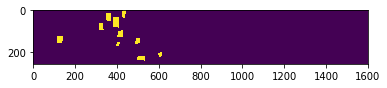

In [28]:
i=0
plt.imshow(y[i].sum(axis=-1))

In [29]:
from tta_wrapper import tta_segmentation

In [30]:
model.load_weights('../input/fromtta/modelB2tta.h5')
print("load_model")
test_df = []
tta_model = tta_segmentation(model, h_flip=True, h_shift=(-10, 10), merge='mean')

for i in range(0, filtered_test_imgs.shape[0], 300):
    batch_idx = list(
        range(i, min(filtered_test_imgs.shape[0], i + 300))
    )
    
    test_generator = DataGenerator(
        batch_idx,
        df=filtered_test_imgs,
        shuffle=False,
        mode='predict',
        base_path='../input/severstal-steel-defect-detection/test_images',
        target_df=filtered_sub_df,
        batch_size=1,
        n_classes=4,aug = None
    )
    
    batch_pred_masks = tta_model.predict_generator(
        test_generator, 
        workers=1,
        verbose=1,
        use_multiprocessing=False
    )
    
    for j, b in tqdm(enumerate(batch_idx)):
        filename = filtered_test_imgs['ImageId'].iloc[b]
        image_df = filtered_sub_df[filtered_sub_df['ImageId'] == filename].copy()
        
#         pred_masks = batch_pred_masks[j, ].round().astype(int)
        pred_masks = batch_pred_masks[j, ]
        pred_masks[pred_masks<0.95]=0
        pred_masks[pred_masks>0.5]=1
        pred_rles = build_rles(pred_masks.astype(int))
        
        image_df['EncodedPixels'] = pred_rles
        test_df.append(image_df)
        
    gc.collect()

load_model
300/300 [==============================] - 74s 248ms/step


300it [00:04, 69.79it/s]


300/300 [==============================] - 62s 207ms/step


300it [00:04, 68.28it/s]


300/300 [==============================] - 62s 207ms/step


300it [00:04, 67.96it/s]


300/300 [==============================] - 62s 207ms/step


300it [00:04, 68.23it/s]


300/300 [==============================] - 62s 206ms/step


300it [00:04, 67.71it/s]


300/300 [==============================] - 62s 207ms/step


300it [00:04, 64.00it/s]


1/1 [==============================] - 0s 226ms/step


1it [00:00,  8.97it/s]


In [31]:
test_df = pd.concat(test_df)
print(test_df.shape)
test_df.head()

(7204, 3)


,ImageId_ClassId,EncodedPixels,ImageId
0,004f40c73.jpg_1,,004f40c73.jpg
1,004f40c73.jpg_2,,004f40c73.jpg
2,004f40c73.jpg_3,,004f40c73.jpg
3,004f40c73.jpg_4,,004f40c73.jpg
4,006f39c41.jpg_1,,006f39c41.jpg


In [32]:
final_submission_df = pd.concat([test_df, null_sub_df])
print(final_submission_df.shape)
final_submission_df.head()

(7204, 3)


,ImageId_ClassId,EncodedPixels,ImageId
0,004f40c73.jpg_1,,004f40c73.jpg
1,004f40c73.jpg_2,,004f40c73.jpg
2,004f40c73.jpg_3,,004f40c73.jpg
3,004f40c73.jpg_4,,004f40c73.jpg
4,006f39c41.jpg_1,,006f39c41.jpg


In [33]:
final_submission_df[['ImageId_ClassId', 'EncodedPixels']].to_csv('submission.csv', index=False)